# 06 - Expectations and observables

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

This notebook covers the calculation of stationary and dynamic expectation values.
These quantities include ensemble averaged observables measurable by experiments,
correlation functions, and spectral densities.

For this notebook, we assume familiarity with 
- data loading/visualization ([Notebook 01 ➜ 📓](01-data-io-and-featurization.ipynb))
- dimension reduction ([Notebook 02 ➜ 📓](02-dimension-reduction-and-discretization.ipynb))
- MSM estimation/validation ([Notebook 03 ➜ 📓](03-msm-estimation-and-validation.ipynb))
- basic analyis techniques ([Notebook 04 ➜ 📓](04-msm-analysis.ipynb) and [Notebook 05 ➜ 📓](05-pcca-tpt.ipynb))

Literature:

- <a id="ref-1" href="#cite-simon-amm">olsson-17</a>
- <a id="ref-2" href="#cite-noe-fingerprints">noe-11</a>
- <a id="ref-3" href="#cite-simon-mech-mod-nmr">olsson-16</a>
- <a id="ref-4" href="#cite-noe-dy-neut-scatt">lindner-13</a>


Maintainers: [@psolsson](https://github.com/psolsson), [@cwehmeyer](https://github.com/cwehmeyer)

**Remember**:
- to run the currently highlighted cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- to get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;
- you can find the full documentation at [PyEMMA.org](http://www.pyemma.org).

---

We recall that a (stationary) ensemble average $\langle O \rangle$ is defined by a Boltzmann-weighted average with the potential energy function $E(\cdot)$:

$$ \langle O \rangle = \mathcal{Z}^{-1}\int_{\Omega}\;\mathrm{d}x\, o(x)\exp(-\beta E(x)) $$

where $x \in \Omega$ is a molecular configuration and $o(\cdot)$ is a function which relates the atomic coordinates of a configuration to a time-independent, microscopic observable.
The function $o(\cdot)$ is often called a 'forward model';
it frequently involves computing distances or angles between particular atoms.
For MSMs we have discretized our configurational space $\Omega$, which simplifies the expression to the sum

$$ \langle O \rangle = \sum_i \pi_i \mathbf{o}_i $$

where $\pi_i$ corresponds to the integrated probability density of the segment of configuration space assigned to Markov state $i$.
The stationary distribution $\boldsymbol{\pi}$ is computed as the left-eigenvector corresponding to the eigenvalue of $1$ of the MSM transition  matrix.
The mapping of the experimental observable is mapped onto the Markov states as the vector $o$ with elements,

$$ \mathbf{o}_i = \frac{1}{\pi_i\mathcal{Z}} \int_{x\in S_i} \mathrm{d}x\, o(x)\exp(-\beta E(x)). $$

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mdshare
import pyemma

## Case 1: preprocessed, two-dimensional data (toy model)

Again we estimate the MSM for the two-dimensional toy model to perform further analysis on.

/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


initialize kmeans++ centers:   0%|                       | 0/50 [00:00<?, ?it/s]

kmeans iterations:   0%|                                 | 0/50 [00:00<?, ?it/s]

26-02-25 14:23:43 pyemma.coordinates.clustering.kmeans.KmeansClustering[0] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


/opt/Python-3.11.10/lib/python3.11/site-packages/deeptime/clustering/_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
/home/cadeniran/.local/lib/python3.11/site-packages/numpy/_core/numeric.py:366: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


estimating BayesianMSM:   0%|                             | 0/6 [00:00<?, ?it/s]

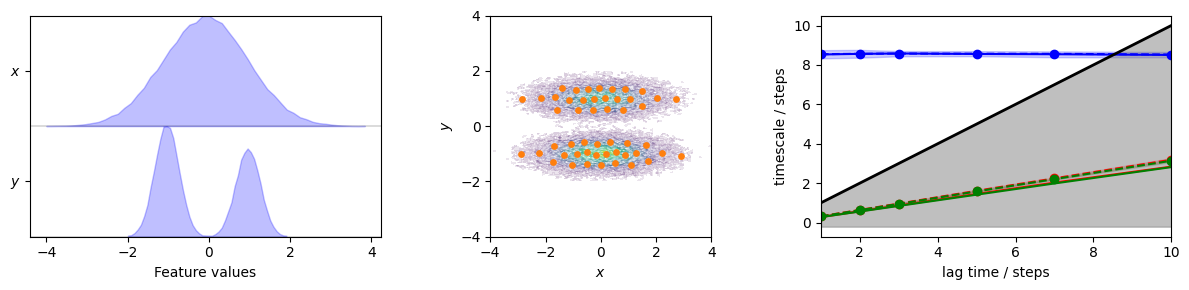

In [2]:
file = mdshare.fetch('hmm-doublewell-2d-100k.npz', working_directory='data')
with np.load(file) as fh:
    data = fh['trajectory']

cluster = pyemma.coordinates.cluster_kmeans(data, k=50, max_iter=50)
dtrajs_concatenated = cluster.dtrajs[0]

its = pyemma.msm.its(
    cluster.dtrajs, lags=[1, 2, 3, 5, 7, 10], nits=3, errors='bayes')

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(
    data, feature_labels=['$x$', '$y$'], ax=axes[0])
pyemma.plots.plot_density(*data.T, ax=axes[1], cbar=False, alpha=0.1)
axes[1].scatter(*cluster.clustercenters.T, s=15, c='C1')
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$y$')
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)
axes[1].set_aspect('equal')
pyemma.plots.plot_implied_timescales(its, ylog=False, ax=axes[2])
fig.tight_layout()

pyemma.msm.estimators.bayesian_msm.BayesianMSM[5]: Sampling MSMs:   0%| | 0/100 

fraction of states used = 1.00
fraction of counts used = 1.00


estimating MaximumLikelihoodMSM:   0%|                    | 0/9 [00:00<?, ?it/s]

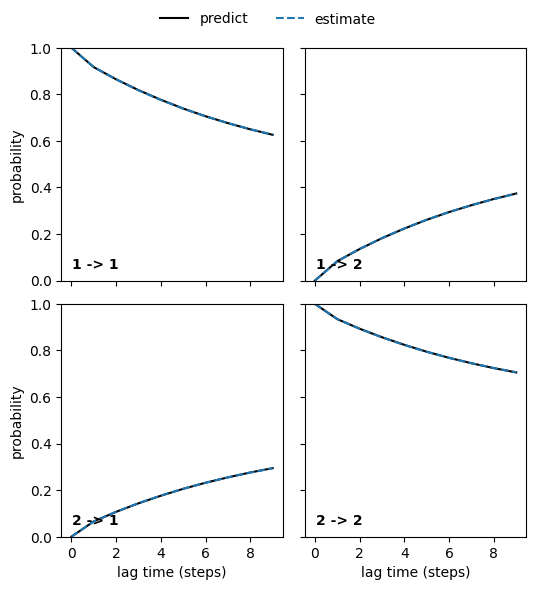

In [3]:
msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=1)
bayesian_msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=1)

print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))

nstates = 2
pyemma.plots.plot_cktest(msm.cktest(nstates));

### An imaginary experiment
Let us first take a look at stationary ensemble averages for this system.
Say the simulation data above represents a protein switching between two metastable configurations,
perfectly separated by the $y$-coordinate.
Imagine then that by inspection of the two metastable configurations,
we have designed an experiment which allows us to measure an observable defined by

$$ o(x,y) = 0.5x + y + 4. $$

We compute the observables for the entire simulation trajectory,
inspect the empirical histograms and the histograms of the metastable sets identified by a two-state PCCA++ analysis.

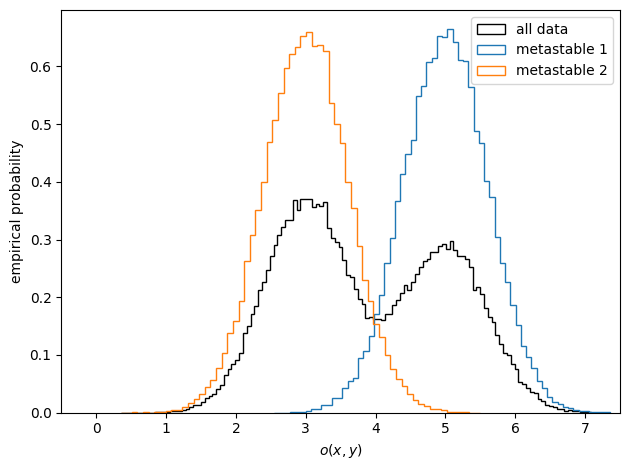

In [4]:
def compute_observable(x, y): 
    return 0.5 * x + y + 4


pcca = msm.pcca(2)
observable_traj = compute_observable(*data.T)

fig, ax = plt.subplots()
ax.hist(
    observable_traj,
    bins=128,
    histtype='step',
    label='all data',
    color='k',
    density=True)
for num, metastable_set in enumerate(pcca.metastable_sets):
    traj_indices = np.where(np.isin(dtrajs_concatenated, metastable_set))[0]
    ax.hist(
        observable_traj[traj_indices],
        bins=64,
        density=True,
        histtype='step',
        label='metastable {}'.format(num + 1))
ax.legend()
ax.set_xlabel(r'$o(x, y)$')
ax.set_ylabel('empirical probability')
ax.set_xlim(-0.5, 7.5)
fig.tight_layout()

In the case of nonequilibrium data, one might wish to compute a reweighted instead of the empirical distribution.
To do so, we have to pass the output of `msm.trajectory_weights()` as weights for the histogramming as shown in the left panel below.

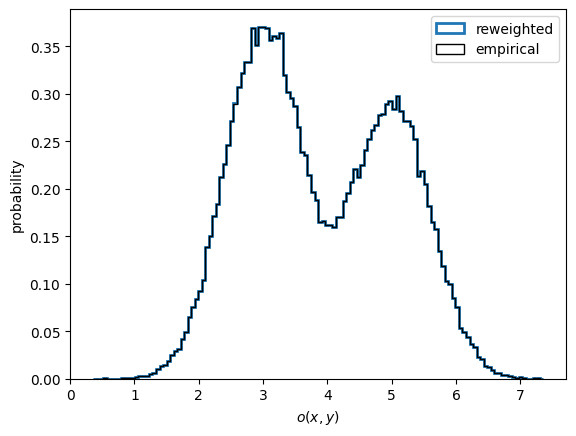

In [5]:
msm_trajectory_weights = msm.trajectory_weights()[0]

fig, ax = plt.subplots()
ax.hist(
    observable_traj,
    bins=128,
    weights=msm_trajectory_weights,
    histtype='step',
    label='reweighted',
    color='C0',
    lw=2,
    density=True)
ax.hist(
    observable_traj,
    bins=128,
    histtype='step',
    label='empirical',
    color='k',
    density=True)
ax.set_xlabel('$o(x, y)$')
ax.legend()
ax.set_ylabel('probability');

In the present case, the data is well equilibrated and we see no difference between the empirical and the properly reweighted distribution. 

In the experiment we have measured this observable to be equal to $3.5$ a.u.
In order to compute this experimental observable from our MSM from above, we need to compute the experimental observable for each of our Markov states by taking the average within the Markov state:

$$ \mathbf{o}_i = \frac{1}{N_{a \in S_i} } \sum_{a \in S_i} o(a_x,a_y). $$

In [6]:
observable_mapped = np.array([observable_traj[dtrajs_concatenated == i].mean()
                              for i in range(cluster.n_clusters)])

Let us visualize the observable on the cluster centers and compare to the stationary distribution of our Markov model:

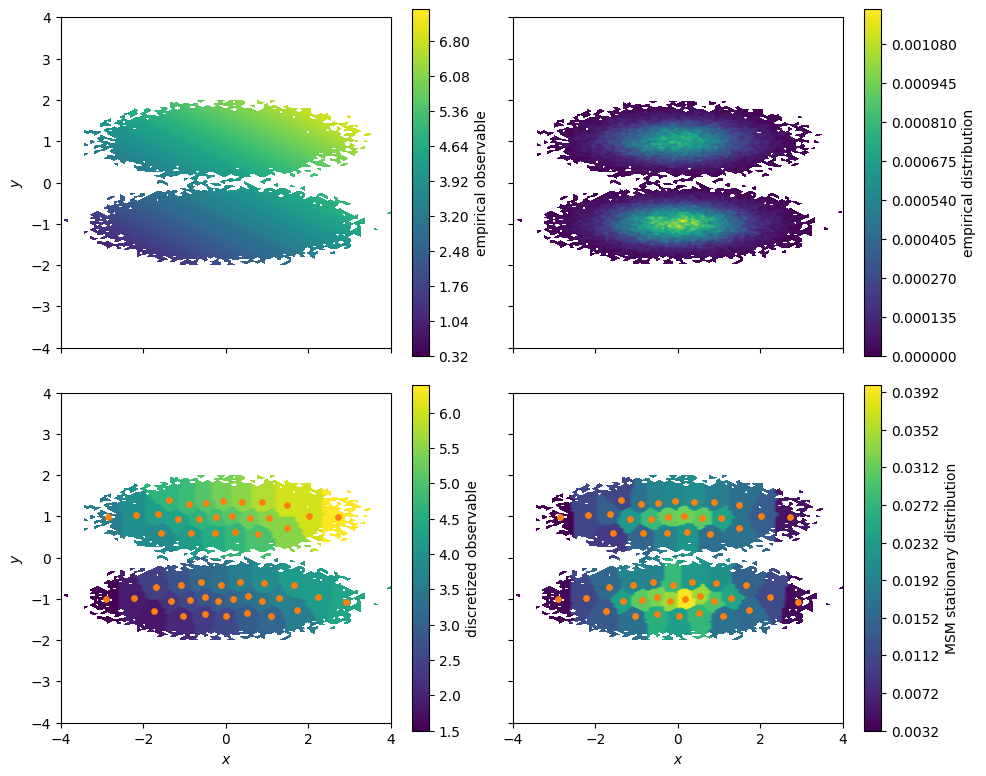

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
pyemma.plots.plot_contour(
    *data.T,
    observable_traj,
    ax=axes[0, 0],
    cbar_label='empirical observable',
    mask=True)
pyemma.plots.plot_density(
    *data.T,
    ax=axes[0, 1],
    cbar_label='empirical distribution')
pyemma.plots.plot_contour(
    *data.T,
    observable_mapped[dtrajs_concatenated],
    ax=axes[1, 0],
    cbar_label='discretized observable',
    mask=True)
pyemma.plots.plot_contour(
    *data.T,
    msm.stationary_distribution[dtrajs_concatenated],
    ax=axes[1, 1],
    cbar_label='MSM stationary distribution',
    mask=True)
for ax in axes.flat:
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_aspect('equal')
for ax in axes[1, :]:
    ax.scatter(*cluster.clustercenters.T, s=15, c='C1')
    ax.set_xlabel('$x$')
for ax in axes[:, 0]:
    ax.set_ylabel('$y$')
fig.tight_layout()

These plots illustrate how we lose some resolution in our observable when clustering the data.
The reason is that the observable is considered constant at the sample average of all simulation frames assigned to a given cluster.
With our vector of observables for our experiment we can compute the ensemble average by using the `expectation` method of our MSM:

In [8]:
print('Experimental result {:.3f}'.format(3.5))
print('Prediction from MSM {:.3f}'.format(msm.expectation(observable_mapped)))

Experimental result 3.500
Prediction from MSM 3.880


We observe that our Markov model has a small deviation from the "experimental" value which we, in a practical case,
would have to gauge against imprecisions in the prediction of the observable
(some contributions include: approximations involving the forward model, the dicretization/projection error and limited sampling)
and the experimental uncertainty.

### Computing observables with error-bars

If we have estimated a Bayesian MSM or HMM,
we can compute limited sampling contribution to our experimental observable prediction by computing sample averages and confidence intervals.

In [9]:
observable_sample_mean = bayesian_msm.sample_mean('expectation', observable_mapped)
print('Bayesian Markov state model confidence interval {:.0f}%'.format(
    bayesian_msm.conf * 100))

observable_ci = bayesian_msm.sample_conf('expectation', observable_mapped)
print('Observable prediction: {:.2f}, CI: [{:.2f}, {:.2f}]'.format(
    observable_sample_mean,  *observable_ci))

Bayesian Markov state model confidence interval 95%
Observable prediction: 3.88, CI: [3.86, 3.90]


We have designed a new complementary experiment which is now given by

$$o_2(x,y) = (y+2)^2 + x. $$

#### Exercise 1
Compute the difference of our MSM prediction of this observable to the experimental value of $5$ a.u.
Compute the sample average and confidence interval from our Bayesian MSM.
Is the experimental value within within the $95\%$ confidence interval?

In [ ]:
def compute_new_observable(x, y):
    return #FIXME


new_observable_traj = #FIXME
new_observable_mapped = np.array([observable_traj[dtrajs_concatenated == i].mean()
                                  for i in range(cluster.n_clusters)])


def is_within(x, a, b):
    return ' not ' if x < a or x > b else ' '


experiment2 = 5.0
msm_prediction = #FIXME
bayesian_msm_sample_mean = #FIXME
bayesian_msm_ci95 = #FIXME

print('Difference between MSM and experiment {:.2f}'.format(experiment2 - msm_prediction))

print('Expl. {:.1f}, Sample mean {:.2f} and CI [{:.2f}, {:.2f}]'.format(
    experiment2,
    bayesian_msm_sample_mean,
    *bayesian_msm_ci95))
print('Experiment is{}within the 95% CI of the Bayesian MSM'.format(
    is_within(experiment2, *bayesian_msm_ci95)))

###### Solution

In [ ]:
def compute_new_observable(x, y):
    return (2 + y)**2 + x


new_observable_traj = compute_new_observable(*data.T)
new_observable_mapped = np.array([observable_traj[dtrajs_concatenated == i].mean()
                                  for i in range(cluster.n_clusters)])


def is_within(x, a, b):
    return ' not ' if x < a or x > b else ' '


experiment2 = 5.0
msm_prediction = msm.expectation(new_observable_mapped)
bayesian_msm_sample_mean = bayesian_msm.sample_mean('expectation', new_observable_mapped)
bayesian_msm_ci95 = bayesian_msm.sample_conf('expectation', new_observable_mapped)

print('Difference between MSM and experiment {:.2f}'.format(experiment2 - msm_prediction))

print('Expl. {:.1f}, Sample mean {:.2f} and CI [{:.2f}, {:.2f}]'.format(
    experiment2,
    bayesian_msm_sample_mean,
    *bayesian_msm_ci95))
print('Experiment is{}within the 95% CI of the Bayesian MSM'.format(
    is_within(experiment2, *bayesian_msm_ci95)))

In cases like these, we can use the Augmented Markov models (AMMs) to estimate MSMs which optimally balance experimental and simulation data <a id="ref-5" href="#cite-simon-amm">olsson-16</a>.
A walkthrough tutorial can be found here: http://www.emma-project.org/latest/generated/augmented_markov_model_walkthrough.html

## Case 2: low-dimensional molecular dynamics data (alanine dipeptide)

We fetch the alanine dipeptide data set, load the backbone torsions into memory,
discretize the full space using $k$-means clustering,
visualize the marginal and joint distributions of both components as well as the cluster centers,
and show the ITS convergence:

In [ ]:
pdb = mdshare.fetch('alanine-dipeptide-nowater.pdb', working_directory='data')
files = mdshare.fetch('alanine-dipeptide-*-250ns-nowater.xtc', working_directory='data')

feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(periodic=False)
data = pyemma.coordinates.load(files, features=feat)
data_concatenated = np.concatenate(data)

cluster = pyemma.coordinates.cluster_kmeans(
    data, k=100, max_iter=50, stride=10)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

its = pyemma.msm.its(
    cluster.dtrajs, lags=[1, 2, 5, 10, 20, 50], nits=4, errors='bayes')

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(
    data_concatenated, feature_labels=['$\Phi$', '$\Psi$'], ax=axes[0])
pyemma.plots.plot_density(*data_concatenated.T, ax=axes[1], cbar=False, alpha=0.1)
axes[1].scatter(*cluster.clustercenters.T, s=15, c='C1')
axes[1].set_xlabel('$\Phi$')
axes[1].set_ylabel('$\Psi$')
pyemma.plots.plot_implied_timescales(its, ax=axes[2], units='ps')
fig.tight_layout()

We estimate a Markov model at a lagtime of $10$ ps and do a Chapman-Kolmogorov validation:

In [ ]:
msm = pyemma.msm.estimate_markov_model(
    cluster.dtrajs, lag=10, dt_traj='0.001 ns')

print('fraction of states used = {:f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:f}'.format(msm.active_count_fraction))

bayesian_msm = pyemma.msm.bayesian_markov_model(
    cluster.dtrajs, lag=10, dt_traj='0.001 ns')

nstates = 4
pyemma.plots.plot_cktest(bayesian_msm.cktest(nstates), units='ps')

msm.pcca(nstates)
bayesian_msm.pcca(nstates);

## Using PyEMMA `coordinates` module to aid computation of molecular observables

In this case we want to make use of features computed from molecular trajectory with the help of the PyEMMA `coordinates` module.
For this small molecular systems we will focus on the $^1H^N-^1H^{\alpha}$ $^3J$-coupling,
a NMR parameter which is sensitive to the dihedral between the plane spanned by the inter-atomic vectors of H-N and N-C$\alpha$ and the plane spanned by H$\alpha$-C$\alpha$ and C$\alpha$-N.
A common forward model to back-calculate $^3J$-couplings from a molecular configurations is called the Karplus equation

$$ ^3J(\theta) = A\cos^2{\theta}+B\cos{\theta} + C, $$

where the (Karplus) parameters $A$, $B$ and $C$ are empirical constants which depend on the properties of the atoms involved in the observable.
Here, we use the values $A=8.754 \, \mathrm{Hz}$, $B=−1.222\, \mathrm{Hz}$ and $C=0.111\, \mathrm{Hz}$.

In [ ]:
feat2 = pyemma.coordinates.featurizer(pdb)
feat2.add_dihedrals([[7, 6, 8, 9]], periodic=False)  # add relevant dihedral
print('Atoms involving dihedral: {}'.format(
    [feat2.topology.atom(i) for i in [7, 6, 8, 9]]))

dihedral_trajs = pyemma.coordinates.load(files, features=feat2)  # load to memory


def Karplus(theta):
    """The forward model."""
    return 8.754 * np.cos(theta)**2 - 1.222 * np.cos(theta) + 0.111


# evaluate forward model on all dihedral trajectories
observable_trajs = [Karplus(traj.ravel()) for traj in dihedral_trajs]
observable_trajs_concatenated = np.concatenate(observable_trajs)

# compute observable for Markov states
jcoupl_markov = np.array([
    observable_trajs_concatenated[dtrajs_concatenated == i].mean()
    for i in range(cluster.n_clusters)])

Let us visualize this observable along with the stationary distribution as above:

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_contour(
    *data_concatenated.T,
    jcoupl_markov[dtrajs_concatenated],
    ax=axes[0],
    cbar_label='$^3J$-coupling / Hz',
    mask=True)
pyemma.plots.plot_contour(
    *data_concatenated.T,
    msm.pi[dtrajs_concatenated],
    ax=axes[1],
    cbar_label='MSM stationary distribution',
    mask=True)
for ax in axes.flat:
    ax.scatter(*cluster.clustercenters.T, s=5, c='C1')
    ax.set_xlabel('$\Phi$')
    ax.set_aspect('equal')
axes[0].set_ylabel('$\Psi$')
fig.tight_layout()

#### Exercise 2
Predict the value of the $^3J$-coupling using the `msm` instance of 2-Ala.

In [ ]:
predicted_3j #FIXME
print('Predicted value of 3J coupling {:.3f} Hz'.format(predicted_3j))

###### Solution

In [ ]:
predicted_3j = msm.expectation(jcoupl_markov)
print('Predicted value of 3J coupling {:.3f} Hz'.format(predicted_3j))

#### Exercise 3

Compute the sample mean and sample standard deviation of the $^3J$-coupling using the `bayesian_msm` instance of 2-Ala.

**Hint**: use the `sample_std` method.

In [ ]:
bayesian_sample_mean_3j = #FIXME
bayesian_ci_3j = #FIXME

print('Predicted 3J coupling {:.3f} ({:.3f}) Hz'.format(
    bayesian_sample_mean_3j, bayesian_ci_3j))

###### Solution

In [ ]:
bayesian_sample_mean_3j = bayesian_msm.sample_mean('expectation', jcoupl_markov)
bayesian_ci_3j = bayesian_msm.sample_std('expectation', jcoupl_markov)

print('Predicted 3J coupling {:.3f} ({:.3f}) Hz'.format(
    bayesian_sample_mean_3j, bayesian_ci_3j))

## Dynamic/kinetic experimental observables

We can measure kinetic information experimentally through time-correlation functions or spectral densities.
Markov models are probabilistic models of the dynamics, i.e.,
if we have an ergodic dynamics described by a Markov model,
we can compute the equilibrium time-correlation functions using

$$ \mathbb{E}[o(x_{t})o(x_{t+k\tau})] = \underbrace{\mathbf{o}^T}_{\text{transpose of vector of observables in Markov states}} \overbrace{\boldsymbol{\Pi}}^{\text{diagonal matrix of stationary distribution}} \underbrace{\mathbf{P}^k(\tau)}_{\text{transition matrix}} \overbrace{\mathbf{o}}^{\text{vector of observables in Markov states}} $$

We can recast this expression to

$$ \mathbb{E}[o(x_{t})o(x_{t+k\tau})] = (\mathbf{o}^T\boldsymbol{\pi})^2 + \sum^N_{i=2} \exp\left(-\frac{k\tau}{t_i}\right)(\mathbf{o}^T\boldsymbol{\phi}_i)^2 $$

by using the spectral decomposition of the transition matrix ([1](#References)).
$\phi_i$ is the $i$th left eigenvector of $\mathbf{P}(\tau)$, with the associated implied timescale $t_i$.
We see that the auto-correlation functions take the form of a multi-exponential decay. 

We now consider relaxation from a nonequilibrium state $\mathbf{p_0}$, which can be achieved by T-jump or P-jump experiments.
In this case, the initial distribution and final ensembles are not the same ($\mathbf{p_0}$ and $\boldsymbol{\pi}$) and so the auto-correlation becomes:

$$ \mathbb{E}[o(x_{t})o(x_{t+k\tau})] = (\mathbf{\hat p_0}^T\boldsymbol{\pi})(\mathbf{l}^T\boldsymbol{\pi}) + \sum^N_{i=2} \exp\left(-\frac{k\tau}{\lambda_i}\right)(\mathbf{o}^T\boldsymbol{\phi}_i)(\mathbf{\hat p_0}^T\boldsymbol{\phi}_i) $$

with $\mathbf{\hat p_0}=\boldsymbol{\Pi}^{-1}\mathbf{p_0}$.


In PyEMMA, the MSM and HMM objects have the methods `correlation` and `relaxation` which implement calculation of auto-correlation in equilibrium and relaxation from a specified nonequilibrium distribution.
Many experimental observables do not measure correlation functions directly but some quantity which depends on a correlation function, or its Fourier transform ([2-3](#References)).
In many of these cases it is possible to obtain analytical expressions of the observable which depends only on the amplitudes $(\mathbf{o}^T\boldsymbol{\phi}_i)^2$ and time-scales $t_i$,
quantities which can be computed given $\mathbf{o}$ using the `fingerprint_correlation` and `fingerprint_relaxation` methods of the MSM or HMM objects. 

We here compute the auto-correlation function of the distance between the amide and alpha protons.

In [ ]:
feat3 = pyemma.coordinates.featurizer(pdb)
feat3.add_distances([[7, 9]], periodic=False)  # add relevant distance
print('Distance between atoms: {}'.format(
    [feat3.topology.atom(i) for i in [7, 9]]))

proton_distance_trajs = pyemma.coordinates.load(files, features=feat3)  # load to memory

In [ ]:
dist_markov = np.array([
    np.concatenate(proton_distance_trajs).flatten()[dtrajs_concatenated == i].mean() 
    for i in range(cluster.n_clusters)])

In [ ]:
eq_time_ml, eq_acf_ml = msm.correlation(dist_markov, maxtime=15)

eq_time_bayes, eq_acf_bayes = bayesian_msm.sample_mean(
    'correlation',
    dist_markov,
    maxtime=15)

eq_acf_bayes_ci_l, eq_acf_bayes_ci_u = bayesian_msm.sample_conf(
    'correlation',
    dist_markov,
    maxtime=15)

fig, ax = plt.subplots()
ax.plot(eq_time_ml, eq_acf_ml, '-o', color='C1', label='ML MSM')
ax.plot(
    eq_time_bayes,
    eq_acf_bayes,
    '--x',
    color='C0',
    label='Bayes sample mean')
ax.fill_between(
    eq_time_bayes,
    eq_acf_bayes_ci_l[1],
    eq_acf_bayes_ci_u[1],
    facecolor='C0',
    alpha=0.3)
ax.semilogx()

ax.set_xlim(eq_time_ml[1], eq_time_ml[-1])
ax.set_ylim([x * 0.999 if i==0 else x * 1.001 for i, x in enumerate(ax.get_ylim())])
ax.set_xlabel(r'time / $\mathrm{ns}$')
ax.set_ylabel(r'd($^{\alpha}$H, $^{\mathrm{N}}$H) ACF / $\mathrm{nm}^2$')
ax.legend()
fig.tight_layout()

print(eq_time_bayes)

The amplitude of the computed auto-correlation functions is very small.
In experiments, we can often prepare a nonequilibrium ensemble, and measure the relaxation back to the steady-state as discussed above.
In PyEMMA, we simulate such experiments using the `relaxation` method of the `msm` object.
In addition to the arguments required by `correlation`, the `relaxation` computation requires an initial condition $p_0$.
Let's say we can prepare the 2-ALA ensemble such that it coincides with metastable distribution $1$,
as identified by the PCCA++ analysis carried out above:

In [ ]:
eq_time_ml, eq_acf_ml = msm.relaxation(
    msm.metastable_distributions[1],
    dist_markov,
    maxtime=15)

eq_time_bayes, eq_acf_bayes = bayesian_msm.sample_mean(
    'relaxation',
    msm.metastable_distributions[1],
    dist_markov,
    maxtime=15)

eq_acf_bayes_CI_l, eq_acf_bayes_CI_u = bayesian_msm.sample_conf(
    'relaxation', 
    msm.metastable_distributions[1],
    dist_markov,
    maxtime=15)

fig, ax = plt.subplots()
ax.semilogx(eq_time_ml, eq_acf_ml, '-o', color='C1', label='ML MSM')
ax.plot(
    eq_time_bayes,
    eq_acf_bayes,
    '--x',
    color='C0',
    label='Bayes sample mean')
ax.fill_between(
    eq_time_bayes,
    eq_acf_bayes_CI_l[1],
    eq_acf_bayes_CI_u[1],
    facecolor='C0',
    alpha=0.3)
ax.semilogx()

ax.set_xlim((eq_time_ml[1], eq_time_ml[-1]))
ax.set_xlabel(r'time / $\mathrm{ns}$')
ax.set_ylabel(r'Avg. d($^{\alpha}$H, $^{\mathrm{N}}$H) / $\mathrm{nm}$')

ax.legend()
fig.tight_layout()

Much better! This signal is orders of magnitude stronger than the one observed for the auto-correlation function at equilibrium.

### Dynamic fingerprints

A new experiment allows us to measure the quantity:

$$ \sum_{i=2}^N \overbrace{t_i}^{\text{implied timescale }i} \underbrace{(\mathbf{o}^T\boldsymbol{\phi}_i)}_{\text{Fingerprint amplitude } i}$$

where $\mathbf{o}$ is the distance amide and alpha protons mapped onto the Markov states.

#### Exercise 4

Using the `fingerprint_correlation` method, compute the timescales and amplitudes of this new observable.

**Hint**: the vector $\mathbf{o}$ was computed above and is stored in the variable `dist_markov`. 

In [ ]:
def compute_new_observable(timescales, amplitudes):
    return timescales[1:].dot(amplitudes[1:])


timescales, amplitudes = #FIXME

print('Value of new observable {:.3e} nm ns'.format(
    compute_new_observable(timescales, amplitudes)))

###### Solution

In [ ]:
def compute_new_observable(timescales, amplitudes):
    return timescales[1:].dot(amplitudes[1:])


timescales, amplitudes = msm.fingerprint_correlation(dist_markov)

print('Value of new observable {:.3e} nm ns'.format(
    compute_new_observable(timescales, amplitudes)))

## Wrapping up

In this notebook, we have covered how to compute ensemble averaged properties/observables from Markov state models and hidden Markov state models.
We have further covered the quantification of uncertainty in these predictions.
We have specifically discussed the MSM/HMM object methods
* `expectation()` computes the stationary ensemble average of a property.
* `correlation()` computes the equilibrium auto/cross-correlation function of a/two property/properties.
* `relaxation()` computes the relaxation auto/cross-correlation function of a/two property/properties given an initial state distribution.
* `fingerprint_correlation()` computes the amplitudes and time-scales of the MSM/HMM auto/cross-correlation function.
* `fingerprint_relaxation()` computes the amplitudes and time-scales of the MSM/HMM relaxation auto/cross-correlation function.
We have further covered the following object methods to compute statistics from Bayesian MSM/HMMs:
* `sample_mean()` computes the mean of a property over the sampled MSMs/HMMs in a Bayesian model. 
* `sample_conf()` computes the confidence interval of a property over the sampled MSMs/HMMs in a Bayesian model.
* `sample_std()` computes the standard deviation of a property over the sampled MSMs/HMMs in a Bayesian model.

Finally, we have shown how to use these methods together with precomputed observables.

## References

<a id="cite-simon-amm"/><sup><a href=#ref-1>[^]</a><a href=#ref-5>[^]</a></sup>Simon Olsson and Hao Wu and Fabian Paul and Cecilia Clementi and Frank Noé. 2017. _Combining experimental and simulation data of molecular processes via augmented Markov models_. [URL](https://doi.org/10.1073/pnas.1704803114)

<a id="cite-noe-fingerprints"/><sup><a href=#ref-2>[^]</a></sup>F. Noe and S. Doose and I. Daidone and M. Lollmann and M. Sauer and J. D. Chodera and J. C. Smith. 2011. _Dynamical fingerprints for probing individual relaxation processes in biomolecular dynamics with simulations and kinetic experiments_. [URL](https://doi.org/10.1073/pnas.1004646108)

<a id="cite-simon-mech-mod-nmr"/><sup><a href=#ref-3>[^]</a></sup>Simon Olsson and Frank Noé. 2016. _Mechanistic Models of Chemical Exchange Induced Relaxation in Protein NMR_. [URL](https://doi.org/10.1021/jacs.6b09460)

<a id="cite-noe-dy-neut-scatt"/><sup><a href=#ref-4>[^]</a></sup>Benjamin Lindner and Zheng Yi and Jan-Hendrik Prinz and Jeremy C. Smith and Frank Noé. 2013. _Dynamic neutron scattering from conformational dynamics. I. Theory and Markov models_. [URL](https://doi.org/10.1063/1.4824070)

